# Hospital Quality of Care Analysis  
## CMS Hospital Readmissions Reduction Program (FY 2025)

This project analyzes hospital readmission performance using data from the
Centers for Medicare & Medicaid Services (CMS). The goal is to understand how
hospital characteristics and patient volume relate to excess readmission ratios (ERR).


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, f_oneway


In [2]:
df = pd.read_csv("FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv")

df.shape


(18510, 12)

In [3]:
df = df.rename(columns={
    "Facility ID": "facility_id",
    "Facility Name": "facility_name",
    "State": "state",
    "Measure Name": "measure",
    "Number of Discharges": "num_discharges",
    "Number of Readmissions": "num_readmissions",
    "Excess Readmission Ratio": "err",
    "Predicted Readmission Rate": "pred_rate",
    "Expected Readmission Rate": "exp_rate"
})


In [4]:
for col in ["num_discharges", "num_readmissions", "err", "pred_rate", "exp_rate"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [5]:
hospital_df = (
    df.groupby(["facility_id", "facility_name", "state"], as_index=False)
      .agg({
          "num_discharges": "sum",
          "num_readmissions": "sum",
          "err": "mean",
          "pred_rate": "mean",
          "exp_rate": "mean"
      })
)

hospital_df.shape


(3085, 8)

In [6]:
hospital_df["volume_group"] = pd.qcut(
    hospital_df["num_discharges"],
    q=2,
    labels=["Low", "High"]
)


## Exploratory Data Analysis (EDA)

This section explores the distribution of hospital readmission metrics
and examines differences across hospital volume and geography.


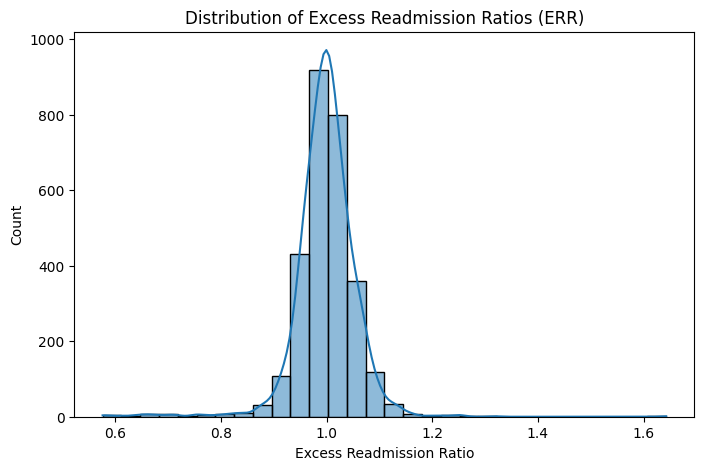

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(hospital_df["err"], bins=30, kde=True)
plt.title("Distribution of Excess Readmission Ratios (ERR)")
plt.xlabel("Excess Readmission Ratio")
plt.ylabel("Count")
plt.show()


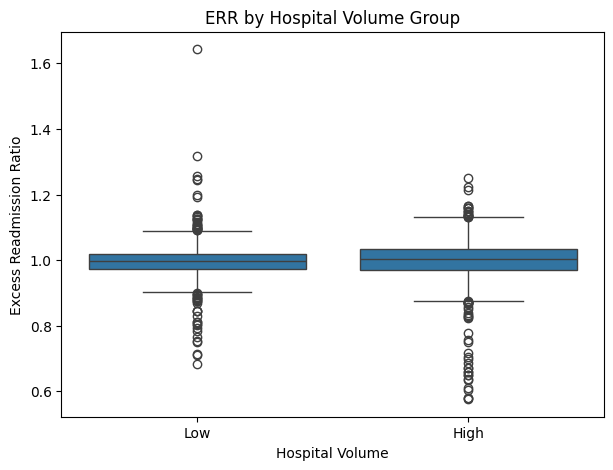

In [9]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=hospital_df,
    x="volume_group",
    y="err"
)
plt.title("ERR by Hospital Volume Group")
plt.xlabel("Hospital Volume")
plt.ylabel("Excess Readmission Ratio")
plt.show()


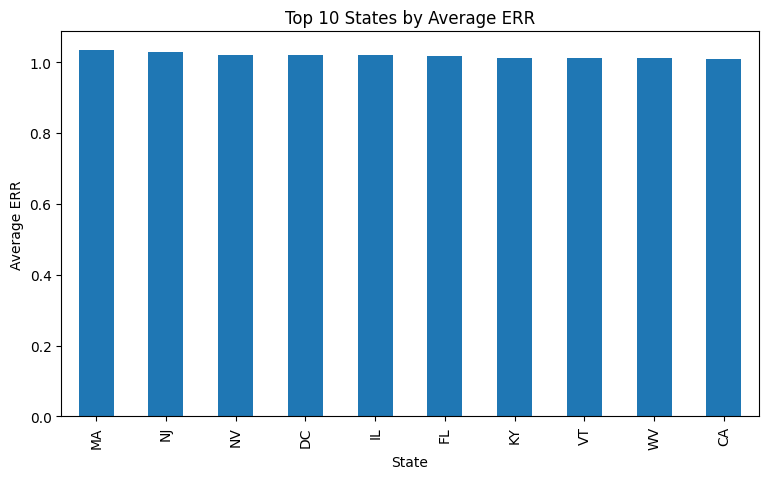

In [10]:
state_err = (
    hospital_df.groupby("state")["err"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(9,5))
state_err.plot(kind="bar")
plt.title("Top 10 States by Average ERR")
plt.xlabel("State")
plt.ylabel("Average ERR")
plt.show()


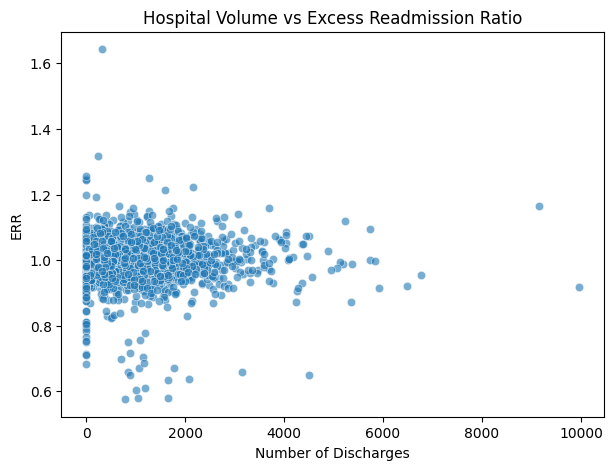

In [11]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=hospital_df,
    x="num_discharges",
    y="err",
    alpha=0.6
)
plt.title("Hospital Volume vs Excess Readmission Ratio")
plt.xlabel("Number of Discharges")
plt.ylabel("ERR")
plt.show()


## Hypotheses

### Hypothesis 1: Hospital Volume and Readmissions
- Null Hypothesis (H0): There is no significant difference in ERR between low-volume and high-volume hospitals.
- Alternative Hypothesis (H1): There is a significant difference in ERR between low-volume and high-volume hospitals.

### Hypothesis 2: Geographic Variation
- Null Hypothesis (H0): ERR does not differ significantly across states.
- Alternative Hypothesis (H1): ERR differs significantly across states.


In [12]:
low = hospital_df[hospital_df["volume_group"]=="Low"]["err"].dropna()
high = hospital_df[hospital_df["volume_group"]=="High"]["err"].dropna()

ttest_ind(low, high, equal_var=False)


TtestResult(statistic=np.float64(-1.8648323090982175), pvalue=np.float64(0.06230756773613951), df=np.float64(2851.4443562168503))

In [13]:
groups = [
    g["err"].dropna()
    for _, g in hospital_df.groupby("state")
    if g["err"].notna().sum() > 20
]

f_oneway(*groups)


F_onewayResult(statistic=np.float64(6.865687347186279), pvalue=np.float64(1.3788255685249473e-31))

## Results

The t-test comparing low- and high-volume hospitals indicates whether patient
volume is associated with differences in excess readmission ratios.

The ANOVA test examines whether readmission performance varies significantly
across states, suggesting potential geographic or policy-related differences
in hospital quality.
